In [3]:
import numpy as np
from numpy import random
from numpy.random import choice
import scipy.stats as stats
import scipy.stats.qmc as qmc

In [73]:
def Quasi_NS(N, mu, var,d):
    # N is the number of samples generated (N=2^m for some m in the natural numbers)
    # mu is the mean of the normal distribution we require samples from
    # var is the variance of the normal distribution we require samples from
    # d is the dimension of the desired sample
    sampler = qmc.Sobol(d=1, scramble=True)
    samples_qmc = sampler.random_base2(m=10)
    Quasi_N_samples = stats.norm.ppf(samples_qmc,mu ,var)
    
    return Quasi_N_samples
    

In [59]:

def multinomial_resampling_qmc(weights):
    N = len(weights)
    
    # Generate Sobol sequence with the number of dimensions equal to the number of particles (N)
    sampler = qmc.Sobol(d=N, scramble=True)
    samples_qmc = sampler.random_base2(m=10)
    
    cumulative_weights = np.cumsum(weights)
    cumulative_weights[-1] = 1.0  # Make sure the last element is exactly 1

    resampled_indices = np.zeros(N, dtype=int)

    # Multinomial resampling
    i, j = 0, 0
    while i < N and j < N:
        if samples_qmc[j, 0] < cumulative_weights[i]:
            resampled_indices[j] = i
            j += 1
        else:
            i += 1

    return resampled_indices

In [35]:
def normpdf(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma)**2) / (np.sqrt(2 * np.pi) * sigma)

#########This function returns quasi random samples from normal distributions##############
def Quasi_NS(N, mu, var,d):
    # N is the number of samples generated (N=2^m for some m in the natural numbers)
    # mu is the mean of the normal distribution we require samples from
    # var is the variance of the normal distribution we require samples from
    # d is the dimension of the sample we require 
    sampler = qmc.Sobol(d, scramble=True)
    samples_qmc = sampler.random_base2(m=10)
    Quasi_N_samples = stats.norm.ppf(samples_qmc,mu ,np.sqrt(var))
    
    return Quasi_N_samples.T


def multinomial_resampling_qmc(weights):
    N = len(weights)
    
    # Generate Sobol sequence with the number of dimensions equal to the number of particles (N)
    sampler = qmc.Sobol(d=N, scramble=True)
    samples_qmc = sampler.random_base2(m=10)
    
    cumulative_weights = np.cumsum(weights)
    cumulative_weights[-1] = 1.0  # Make sure the last element is exactly 1

    resampled_indices = np.zeros(N, dtype=int)

    # Multinomial resampling
    i, j = 0, 0
    while i < N and j < N:
        if samples_qmc[j, 0] < cumulative_weights[i]:
            resampled_indices[j] = i
            j += 1
        else:
            i += 1

    return resampled_indices

def tractable_qsmc_fredholm(N,epsilon, n):
    # N is the number of particles (given as a power of 2)
    # n is the number of sample iterations
    # epsilon is the standard deviation of the Gaussian smoothing kernel
    # mu is the mean of the sample observations 

  
    
    # Initialization
    X_particles = np.zeros((n, N))
    Y_particles = np.zeros((n, N))
    weights = np.zeros((n, N))
    
 
    
    # at time n=1
    # Initial distribution is given as the input 
    X_particles[0, :] = Quasi_NS(N, 0, 0.045,d=1)
    # Uniform weights are given as the input
    weights[0, :] = np.ones(N) / N 
    # Initial distribution of the obeservations is given as the input 
    Y_particles[0, :] = Quasi_NS(N, 0.5, 0.088,d=1)

    # at time n>1
    for i in range(1, n):
        
        # Markov Chain step
        X_particles[i, :] = X_particles[i-1, :] + epsilon * Quasi_NS(N, 0, 1,d=1)

        weights[i, :] = weights[i-1, :]
        # Calculate hN
        hN = np.zeros(N) 
        for j in range(0, N):
            hN[j] = np.mean(weights[i, :] * normpdf(Y_particles[j], X_particles[i, :], 0.045))

        # calculate potentials
        potential = np.zeros(N)
        g = normpdf(Y_particles[i,:], X_particles[i, :], 0.045)
        potential[hN != 0] = g[hN != 0] / hN[hN != 0]
        potential[hN == 0] = 0
        # update and normalize weights 
        weights[i, :] = weights[i, :] * potential

        weights[i, :] = weights[i, :] / np.sum(weights[i, :])

        # Resampling particles with updated weights
        Y_particles[i, :] = choice(Y_particles[i-1,:], N, replace=False)
        
        # Effective Sample Size (ESS)
        ESS = 1 / np.sum(weights[i, :]**2)
        
        # Resampling
        if ESS < N / 2:
            indices = multinomial_resampling_qmc(weights[i, :])
            X_particles[i, :] = X_particles[i, indices]
            weights[i, :] = np.ones(N) / N
        else:
            X_particles[i, :] = X_particles[i-1, :]
            weights[i, :] = weights[i-1, :]

    return X_particles



 

In [36]:
target_data= tractable_qsmc_fredholm(1024,0.01,1000)

IndexError: index 1000 is out of bounds for axis 0 with size 1000

In [17]:
target_data

array([[ 0.08184301, -0.12520744, -0.22605217, ..., -0.22568724,
        -0.12426691,  0.08103524],
       [-0.01513977, -0.01513977, -0.01513977, ...,  0.08197599,
         0.08197599,  0.08197599],
       [-0.01263816, -0.01263816, -0.01263816, ...,  0.08206004,
         0.08206004,  0.08206004],
       ...,
       [ 0.08876591,  0.08876591,  0.08876591, ...,  0.0856759 ,
         0.0856759 ,  0.0856759 ],
       [ 0.08876591,  0.08876591,  0.08876591, ...,  0.0856759 ,
         0.0856759 ,  0.0856759 ],
       [ 0.08876591,  0.08876591,  0.08876591, ...,  0.0856759 ,
         0.0856759 ,  0.0856759 ]])

In [12]:
particle_1 = target_data[0,:]



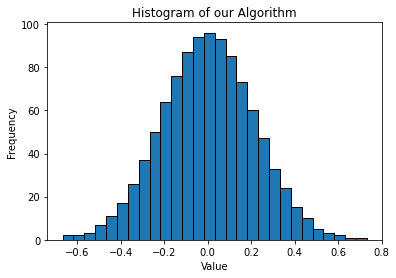

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data as a NumPy array
data = particle_1

# Define bin size
bin_size = 0.05

# Compute bin edges
bins = np.arange(min(data), max(data) + bin_size, bin_size)

# Plot histogram
plt.hist(data, bins=bins, edgecolor='black')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of our Algorithm')

# Show the plot
plt.show()